<i>Befofe using this notebook,
<li>check dependencies and libraries that should be installed using pip</li>
<li>Tested locally on python==3.9.7 on Windows 10</li>
<li>For use of the la_core_web_lg LatinCy consult the appropriate documentation on HuggingFace</li>

In [ ]:
!pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


<b>Import libraries for data processing</b>


In [ ]:
import spacy
import csv
import re
import pandas as pd

<b>Load the specialised latin language model from SpaCy/Latincy</b>


In [ ]:
nlp = spacy.load('la_core_web_lg')

<b>Load the text of Naturalis Historia</b>

In [ ]:
!curl -L -o naturalisHistoria.csv https://raw.githubusercontent.com/Bestroi150/NatHist/main/naturalisHistoria.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2802k  100 2802k    0     0  11.6M      0 --:--:-- --:--:-- --:--:-- 11.6M


<b>Read the corpus data and do a test "print()". Repeat the step before for every separate part of the text</b>

In [ ]:
file = open("naturalisHistoria.csv", "r+")
text = file.read()

In [ ]:
print(text)

Book/Chapter,Text
plin. nat. 1.1,"libro ii continentvr an finitus sit mundus et an unus de forma eius de motu eius. cur mundus dicatur de elementis de deo de siderum errantium natura de lunae et solis defectibus. de nocte de magnitudine siderum quae quis invenerit in observatione caelesti de lunae motu errantium motus et luminum canonica quare eadem altiora, alias propiora videantur catholica siderum errantium quae ratio colores eorum mutet solis motus. dierum inaequalitatis ratio quare fulmina iovi adsignentur intervalla siderum de sideribus musica de mundo geometrica de repentinis sideribus. de cometis. natura et situs et genera eorum hipparchea de sideribus agnoscendis  de caelestibus prodigiis per exempla historica lampades, bolides trabes caelestes, chasma caeli de caeli coloribus de flamma caelesti de coronis caelestibus de circulis repentinis plures soles plures lunae dierum modo noctibus lux clipei ardentes ostentum caeli semel notatum de discursu stellarum de stellis quae cast

<b>step I <br>

Extacting data from the text</b><br>
Firstly we create a function for browsing the text of Naturalis Historia with LatinCy.<br>
We create a iteration to parse through separate tokens of the text (or simply words).<br>
We check if the lemma we are using as input has a token/tokens representing it in the text.<br> For the data to be more helpful we create a context surrounding the token in the<br> text and extract it with parameters:
<ul>
<li>5 before the token</li>
<li>6 after the token</li>
</ul>
making it a total of 12 + the token itself <br> <i>Adjust the parameters according to preference and output</i><br>
We store the information for our query in a variable in this case called "search", which is<br>
essentially a json dictionary.

In [ ]:
def browseNatHist(doc, lemmas):
    data = {lemma: [] for lemma in lemmas}


    for i, token in enumerate(doc):
        for lemma in lemmas:
            if any(token.lemma_.lower().startswith(lemma.lower()) for lemma in lemma):
                start = max(0, i - 5)  #change "5" in this (0, i - 5) for different results
                end = min(len(doc), i + 6)  #change "6" in this (len(doc), i + 6) for different results

                context = doc[start:end]

                search = {
                    'lemma': lemma,
                    'location': f'plin.nat.{get_book_chapter(doc, i)}',
                    'context': ' '.join([token.text for token in context]),
                }
                data[lemma].append(search)

    return data

<b>step II<br>

Creating a function to extract data from the dataset<br>
about the location where the token has been used</b><br>

Use a token index for correct placement in the text. <br>
The function will give out a exception of plin.nat.x.x if <br>
there is an issue with the dataset, and it can't point out <br>
the correct place in the text, where the token was used.<br>


<i><b>NB!</b> This code will only work for the text of Plinius Naturalis Historia, because it is hardcoded to work only<br>with the bibliographical abbreviation plin.nat., if you want to use the code block for other texts you should modify it.</i>

In [ ]:
def get_book_chapter(doc, token_index):

    chapter_text = " ".join([sent.text for sent in doc.sents])
    startInd = chapter_text.rfind('<plin. nat.', 0, token_index)
    endInd = chapter_text.find('>', token_index)
    if startInd != -1 and endInd != -1:
        return chapter_text[startInd + 12:endInd]
    else:
        return 'x.x'

<b>step III <br>
Read the data from the dataset produced in the earlier steps</b><br>

<i><b>NB!</b> Use the name you gave to the data set.</i>

<b>The most important part is to write a list of lemmas for the iteration to search for.</b><br>

Keep in mind you should write the base form or lemma of the word you're searching<br>
e.g. if you want to find words with the meaning "temple" or "house" don't <br>
for "templi", "templorum" or "domi", "domuum", because these forms may not be <br>
present in the current dataset, instead search for "templum","domus" etc.<br>

<b>Write the results into a dataframe with appropriate headers, like in this case</b>: <li>lemma</li> <li>context</li> <li>book/chapter</li>

Finally we browse the dataset we created to extract the relevant information from it and print it to the console.

In [ ]:
import string

<b>NB</b> New function to remove punctuation<br>
<i>add it to a more appropriate place</i>

In [ ]:
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

<b>Use the following steps with caution and modify according to research needs</b>

In [ ]:
data = pd.read_csv("naturalisHistoria.csv")

search_lemmas = [('domus',), ('villa',), ('templum',)] # change this, keep in mind the syntax: ('lemma',)

results_df = pd.DataFrame(columns=['Lemma', 'Context', 'Book/Chapter'])

for index, row in data.iterrows():

    text = remove_punctuation(row["Text"])
    doc = nlp(text)

    search_results = browseNatHist(doc, search_lemmas)

    for lemma_tuple, find in search_results.items():
        for search in find:
            lemma = search['lemma']
            context = search['context'].strip()
            book_chapter = row["Book/Chapter"]


            new_row = pd.DataFrame({'Lemma': [lemma], 'Context': [context], 'Book/Chapter': [book_chapter]})
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            print(results_df)

Предаденият резултат е скъсен до последните 5000 реда.
15    (domus,)  temperie omni adflatu noxio carens domus iis n...   
16    (domus,)  pabulis mapalia sua hoc est domos plaustris ci...   
17    (domus,)  inveniunt ibi restagnantibus mauretaniae aquis...   
18    (domus,)  trogodytae specus excavant hae illis domus vic...   
19  (templum,)  abydus memnonis regia et osiris templo inclutu...   
20  (templum,)  fons in urbe callippia et templum dianae conpl...   
21  (templum,)  chrysa et larisa alia zminthium templum durat ...   
22  (templum,)  amyci dein naulochum promunturium estiae templ...   
23  (templum,)  durat adhuc ibi iovis beli templum inventor hi...   
24  (templum,)  circumit arcem susorum ac dianae templum augus...   
25  (templum,)  sed maximis nagia et thomna templorum lxv haec...   
26  (templum,)  atramitae quorum caput sabota lx templa muris ...   
27    (domus,)  gorgades insulae narrantur gorgonum quondam do...   
28  (templum,)  et miraculi gratia in iunonis te

<b>step VI<br>We write the newly created dataframe into a dataset with the appropriate name.</b>

In [ ]:
results_df.to_csv('output_results.csv', index=False) #change the name of the dataframe output_results.csv

In [ ]:
!ls  #confirm that your file is created
# your file is supposed to be in the third column

naturalisHistoria.csv  output_results.csv  sample_data


<b>Download your file to your local machine</b>

In [ ]:
from google.colab import files

files.download('output_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<b>step V</b><br><b>Load your dataset here for basic vizualization</b>


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv("output_results.csv")  # change this to the name of your dataset

<ipython-input-16-9539b79d3e9f>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


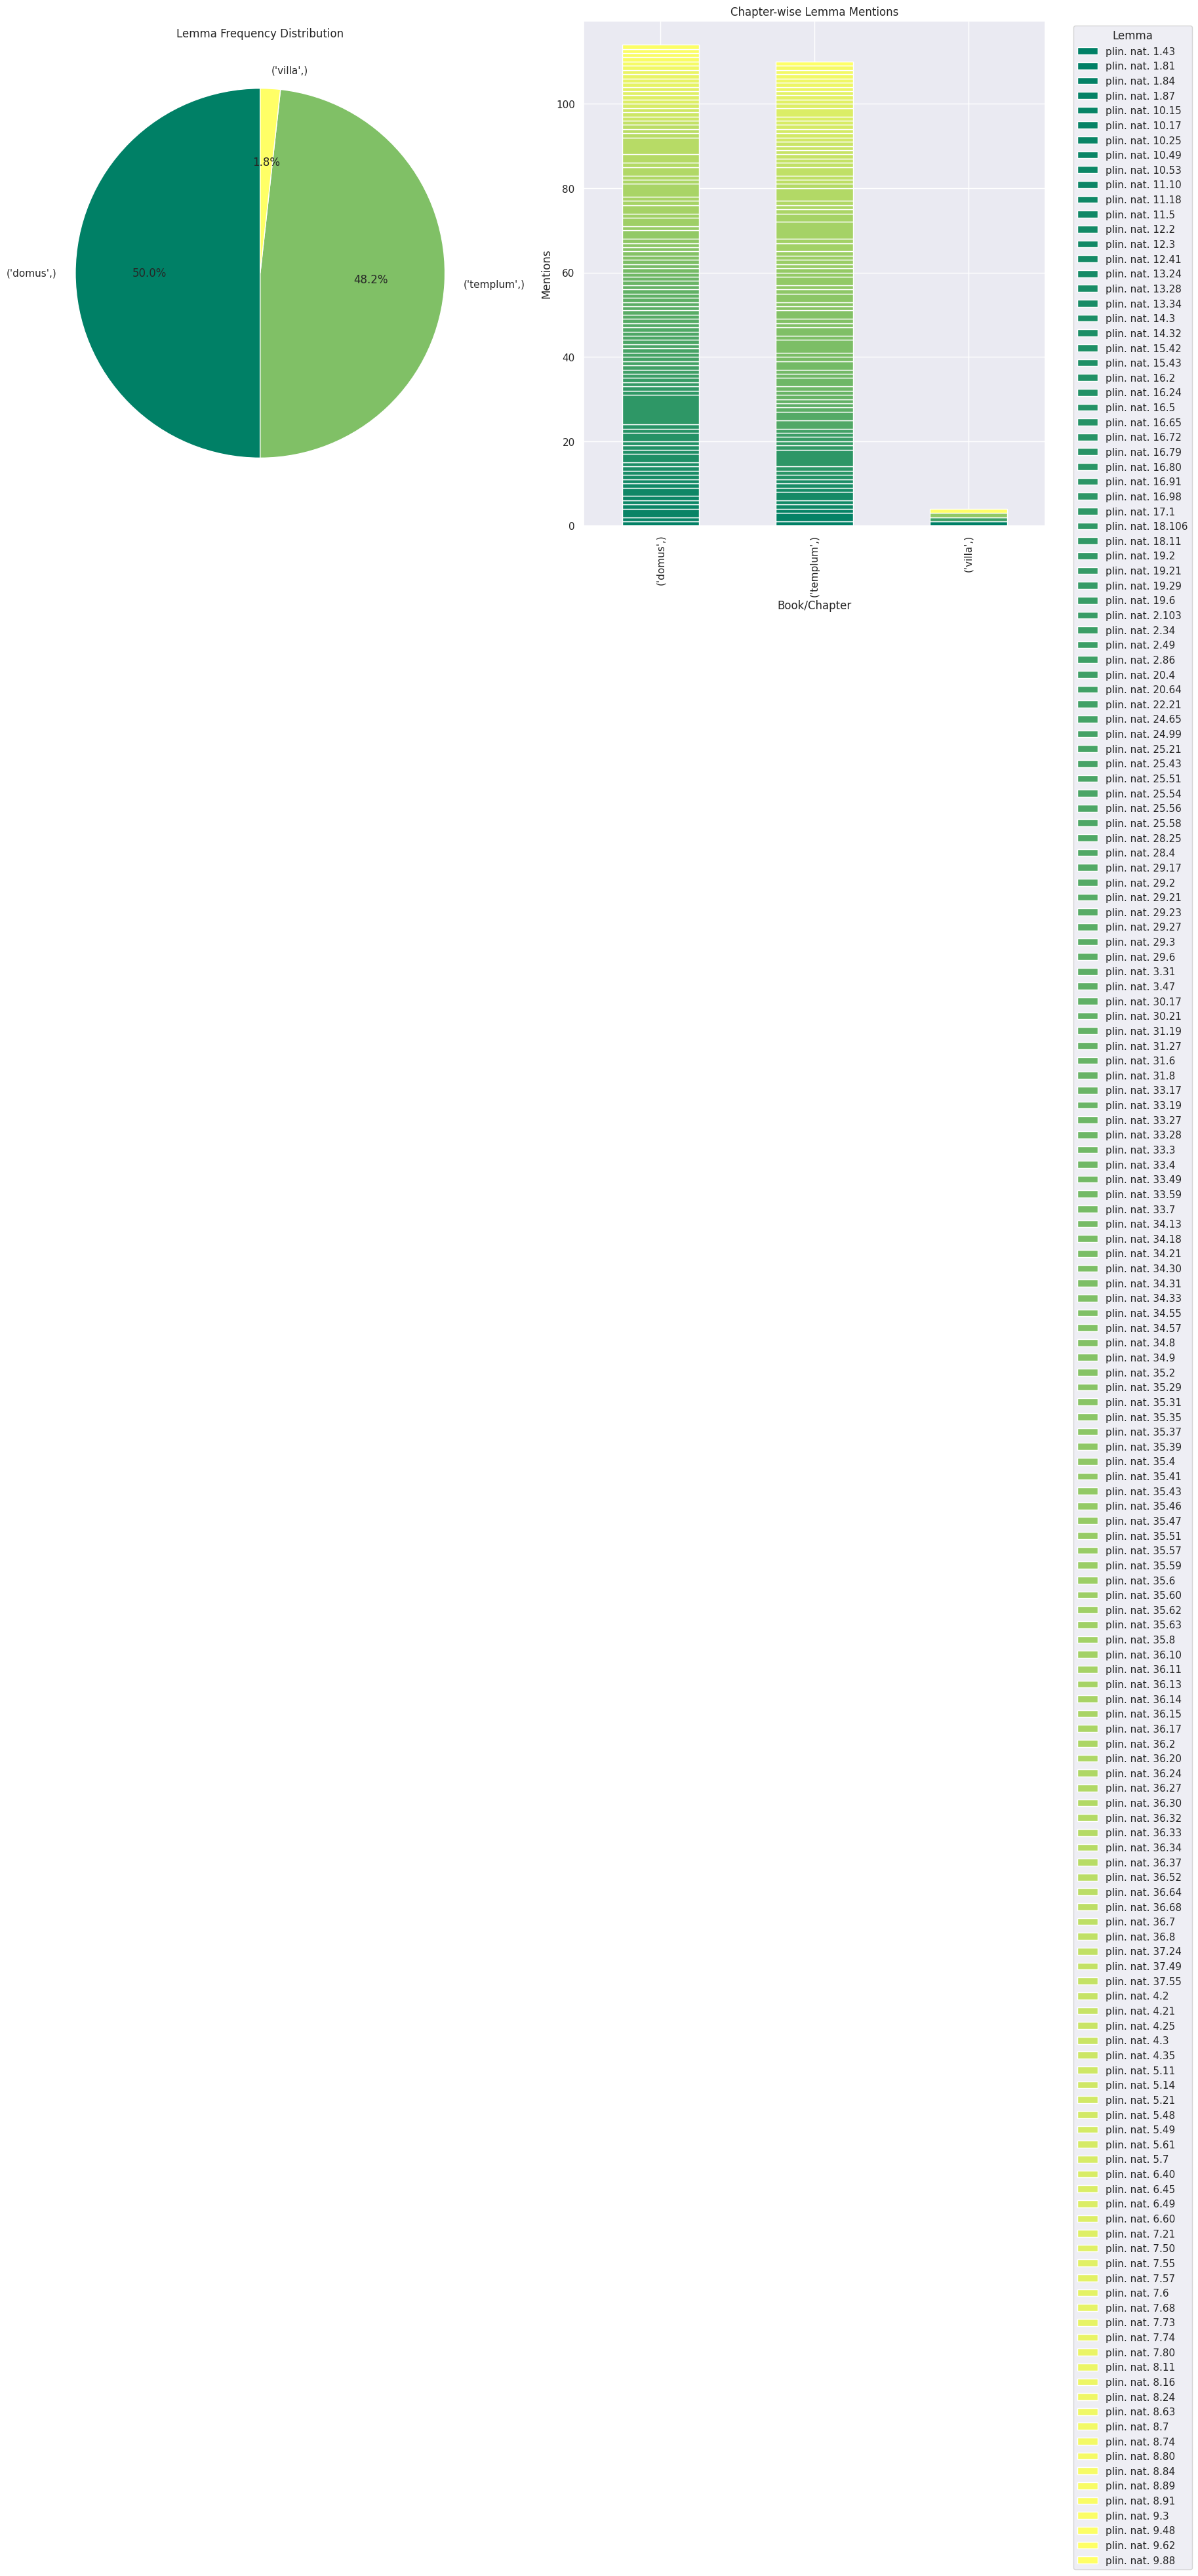

In [ ]:
sns.set_theme()

lemma_stats = data['Lemma'].value_counts().reset_index()
lemma_stats.columns = ['Lemma', 'Frequency']

most_common_lemma = lemma_stats.iloc[0]['Lemma']

chapter_stats = data.groupby(['Lemma', 'Book/Chapter']).size().unstack(fill_value=0)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

cmap = plt.get_cmap('summer')
colors = [cmap(i) for i in np.linspace(0, 1, len(lemma_stats['Lemma']))]

axs[0].pie(lemma_stats['Frequency'], labels=lemma_stats['Lemma'], autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('Lemma Frequency Distribution')

chapter_stats.plot(kind='bar', stacked=True, ax=axs[1], colormap='summer')
axs[1].set_title('Chapter-wise Lemma Mentions')
axs[1].set_xlabel('Book/Chapter')
axs[1].set_ylabel('Mentions')
axs[1].legend(title='Lemma', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Most Common Lemma: {most_common_lemma}")

Most Common Lemma: ('domus',)
